<!-- Notebook Header Start -->

<h1 align="center">Changes to Noxious Stimuli by means of Dorsal Root Ganglion Stimulation</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-12-06<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Importing libraries & data**
* **Preprocess neurophysiology recordings for spike sorting**
* **Package preprocessed data for spike sorting using Kilosort4**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during noxious stimuli**
* **Compare the firing rates of clusters before and after noxious stimuli**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# ➡ Importing Libraries & Data
---

In [1]:
# standard imports
from pathlib import Path
import os
from kilosort import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import seaborn as sns
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots
from automations import analysis_functions


### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
PROBE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')

### filepath definitions

In [3]:
# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# save data to the inbox; make sure that the folders: binary & figures exist

# select your path

# the following save directory has already been run, and it stores data that has been unaltered
SAVE_DIRECTORY = Path(fr"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.011 Mult_Rat_Linear_Mixed_Effects_all_mua")

# Create paths if they don't exist
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)

# run a multi-rat class

In [4]:
rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW322', 'DW323', 'DW327']]
group = RM1.RatGroup(rats)
group.run_preprocessing(remove_drg_stim=True)  # preprocess all rats at once

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233: stream_id 2 is not in ['0', '1', '3', '4']
Re

In [5]:
group.rats.keys()

dict_keys(['DW322', 'DW323', 'DW327'])

## run spikeinterface

In [6]:
si_wrappers = group.create_spikeinterface_wrappers(SAVE_DIRECTORY)
for rat_id in si_wrappers.keys():
    # si_wrappers[rat_id].save_spinalcord_data_to_binary()
    pass

Preparing SpikeInterface wrapper for rat DW322
Preparing SpikeInterface wrapper for rat DW323
Preparing SpikeInterface wrapper for rat DW327


## kilosort

In [7]:
ks_wrappers = group.create_kilosort_wrappers(SAVE_DIRECTORY, probe_directory=PROBE_DIRECTORY)
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):
    # Example criteria: Contamination rate < 0.99 and firing rate between 0.1 and 1000 Hz
    contam_good = est_contam_rate < 0.99
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.1 <= fr <= 1000:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

Preparing Kilosort wrapper for DW322
Preparing Kilosort wrapper for DW323
Preparing Kilosort wrapper for DW327


In [8]:
for rat_id in ks_wrappers.keys():
    # ks_wrappers[rat_id].run_kilosort_trial_summary(new_settings="vf_settings",custom_criteria=my_custom_criteria)
    ks_wrappers[rat_id].extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_1_240918_143256
Kilosort outputs successfully loaded for trial: VF_2_240918_143936
Kilosort outputs successfully loaded for trial: VF_3_240918_144658
Kilosort outputs successfully loaded for trial: VF_4_240918_145638
Kilosort outputs successfully loaded for trial: VF_5_240918_150137
Kilosort outputs successfully loaded for trial: VF_6_240918_150811
Kilosort outputs successfully loaded for trial: VF_7_240918_151516
Kilosort outputs successfully loaded for trial: VF_8_240918_152056
Kilosort outputs successfully loaded for trial: VF_9_240918_152753
Kilosort outputs successfully loaded for trial: VF_1_240911_164342
Kilosort outputs successfully loaded for trial: VF_2_240911_165039
Kilosort outputs successfully loaded for trial: VF_3_240911_165617
Kilosort outputs successfully loaded for trial: VF_4_240911_170446
Kilosort outputs successfully loaded for trial: VF_5_240911_171014
Kilosort outputs successfully loaded for trial: VF_6_240911_17

### generate sanity plots for each trial 

In [9]:
dw322_trials = ["VF_1_240918_143256","VF_2_240918_143936","VF_3_240918_144658","VF_4_240918_145638","VF_5_240918_150137","VF_6_240918_150811","VF_7_240918_151516","VF_8_240918_152056","VF_9_240918_152753"]
dw323_trials = ["VF_1_240911_164342","VF_2_240911_165039","VF_3_240911_165617","VF_4_240911_170446","VF_5_240911_171014","VF_6_240911_171505"]
dw327_trials = ["VF_01_241125_153746","VF_02_241125_154307","VF_03_241125_154841","VF_04_241125_155417","VF_05_241125_155941","VF_06_241125_160515","VF_07_241125_161126","VF_08_241125_161626","VF_09_241125_162141","VF_10_241125_162725"]

##### NOTE:

seeing repeating units is not a sign that there is an issue: these plots a pick random units, (40) times, to show how spikes are captured on the probe. 

the fewer the number of good or mua units, the more likely there will be repeated units.

#### DW322

In [10]:
# ks_wrappers["DW322"].plot_trial_results(dw322_trials)

#### DW323

In [11]:
# ks_wrappers["DW323"].plot_trial_results(dw323_trials)

#### DW327

In [12]:
# ks_wrappers["DW327"].plot_trial_results(dw327_trials)

### plot characteristic waveform for each neuron

#### DW322

In [13]:
# ks_wrappers["DW322"].plot_cluster_waveforms(dw322_trials)

#### DW323

In [14]:
# ks_wrappers["DW323"].plot_cluster_waveforms(dw323_trials)

#### DW3237

In [15]:
# ks_wrappers["DW327"].plot_cluster_waveforms(dw327_trials)

### multi-animal von frey analysis

In [27]:
# Create a multi–rat analysis instance.
multi_analysis = analysis_functions.MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)

# combine all the trials from every animal to plot the results

combined_results = multi_analysis.analyze_all_trials(excel_parent_folder=SAVE_DIRECTORY, subwindow_width=0.5, corr_threshold=0.1)

# use combined_results for further plotting or modeling.

# combined_results now contains results from each rat, loaded from Excel if available.

In [28]:
combined_results["DW322_VF_2_240918_143936"]

{'voltage_df':      avg_voltage      group
 0   272278.37500   pre-stim
 1   289338.81250   pre-stim
 2   274101.43750   pre-stim
 3   227150.00000   pre-stim
 4   288529.34375   pre-stim
 ..           ...        ...
 65  617659.06250  post-stim
 66  664856.37500  post-stim
 67  763105.62500  post-stim
 68  820236.31250  post-stim
 69  646114.18750  post-stim
 
 [70 rows x 2 columns],
 'firing_df':        Unnamed: 0          0          1           2           3          4  \
 0               0  48.000000  36.000000   24.000000   26.000000  68.000000   
 1               1  52.000000  62.000000  114.000000   46.000000  80.000000   
 2               2   0.000000   0.000000    0.000000    0.000000   0.000000   
 3               3   0.000000   0.000000  150.000000  150.000000   0.000000   
 4               4  76.000000  34.000000   62.000000   48.000000  16.000000   
 ..            ...        ...        ...         ...         ...        ...   
 67             67  14.000000  36.000000    8.

Combine the Results and Metadata:
You would need to create (or extract) a DataFrame where each row corresponds to a sub-window (or trial) with columns for the dependent variable (for example, average voltage), the fixed effects (e.g. stimulation, pulse width, waiting), and a column indicating the animal (rat ID). You might need to merge your VonFreyAnalysis results with metadata that specifies stimulation parameters.

Fit a Mixed Effects Model:
Use the statsmodels MixedLM or the formula interface (statsmodels.formula.api.mixedlm) to specify a model with fixed effects for voltage, stimulation, pulse width, waiting and a random intercept for animal.


### example of single-rat experiment properties

In [29]:
group.rats["DW323"].qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,NaN
Trial Number,,,,,,,,,,,
1,1,VF,70,300,5,180,vf,NaN,30,pos 1,pad just prximal from toe
2,2,VF,70,300,20,180,vf,NaN,30,pos 1,NaN
3,3,VF,70,300,100,180,vf,NaN,30,pos 1,NaN
4,4,VF,70,300,100,180,vf,NaN,30,pos 2,toes
5,5,VF,70,300,5,180,vf,NaN,30,pos 2,NaN
6,6,VF,70,300,20,180,vf,NaN,30,pos 2,NaN


### combining the experiment notes for individual animals, for combined plots and linear mixed effects modeling.

In [30]:
def make_unique_cols(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    df.columns = new_cols
    return df

dfs = []
for rat_id, rat in group.rats.items():
    df = make_unique_cols(rat.qst_trial_notes.copy())
    df['Rat ID'] = rat_id
    df["Trial Number"] = rat_id + "_" + df["Trial Number"].astype(str)
    dfs.append(df)

combined_qst_notes = pd.concat(dfs, ignore_index=True)

# Sort keys based on the numeric part after the second underscore (i.e., the zero-padded trial number)
sorted_keys = sorted(
    combined_results.keys(),
    key=lambda x: int(x.split('_')[2])
)

combined_qst_notes['Trial_ID'] = sorted_keys

# After concatenating your DataFrames into combined_qst_notes:
combined_qst_notes['Trial_ID'] = list(combined_results.keys())
combined_qst_notes

,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,Rat ID,nan_1,Trial_ID
0,DW322_1,VF,51,300,5,180,vf,NaN,30,accidentally named DRGS_13,DW322,NaN,DW322_VF_1_240918_143256
1,DW322_2,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_2_240918_143936
2,DW322_3,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_3_240918_144658
3,DW322_4,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_4_240918_145638
4,DW322_5,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_5_240918_150137
5,DW322_6,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_6_240918_150811
6,DW322_7,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_7_240918_151516
7,DW322_8,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_8_240918_152056
8,DW322_9,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_9_240918_152753
9,DW323_1,VF,70,300,5,180,vf,NaN,30,pos 1,DW323,pad just prximal from toe,DW323_VF_1_240911_164342


## plot a composite Von Frey Analysis plot

Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_6_240918_150811. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_

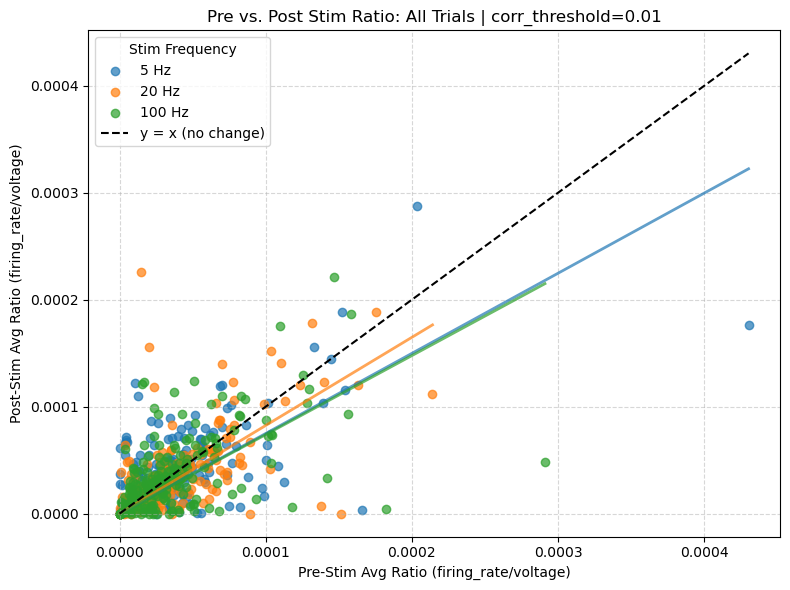

In [31]:
# For example:
plots.vf_all_trials_combined_plot(combined_results, combined_qst_notes,corr_threshold=0.01)

## combine metadata and neuron firing changes for linear effects mixed model

In [21]:
def flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.1):
    """
    Flattens trial data into a single DataFrame, then filters clusters by correlation threshold.
    Only clusters whose absolute correlation meets or exceeds corr_threshold are kept.
    """
    # Create dictionaries for columns you need from combined_qst_notes
    freq_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Freq. (Hz)']))
    amp_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['amp']))
    # Add a rat_id_dict to capture the rat ID from combined_qst_notes
    rat_id_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['Rat ID']))
    pulse_width_dict = dict(zip(combined_qst_notes['Trial_ID'], combined_qst_notes['PW (us)']))



    records = []

    for trial_id, res in combined_results.items():
        # Get frequency and amplitude
        freq_hz = freq_dict.get(trial_id)
        amp_val = amp_dict.get(trial_id)
        rat_id = rat_id_dict.get(trial_id)
        pulse_width = pulse_width_dict.get(trial_id)

        if freq_hz is None or amp_val is None or rat_id is None or pulse_width is None:
            continue

        avg_voltage_df = res.get('voltage_df')
        firing_rates_df = res.get('firing_df')
        if avg_voltage_df is None or firing_rates_df is None:
            continue
        
        # Skip if not enough rows to have correlation data
        if len(firing_rates_df) < 2:
            continue

        # Extract the correlation row (second-to-last row)
        correlation_data = firing_rates_df.iloc[-2]
        # Convert correlation entries to a dictionary keyed by integer cluster IDs
        corr_dict = {
            int(k): v
            for k, v in correlation_data.to_dict().items()
            if str(k).isdigit()
        }

        # Exclude the last two rows (correlation row, plus any extra row if present)
        firing_data = firing_rates_df.iloc[:-2]

        # Melt the firing data to long format: (group, cluster, firing_rate)
        firing_melt = firing_data.melt(
            id_vars=['group'], 
            var_name='cluster', 
            value_name='firing_rate'
        )
        firing_melt['cluster'] = pd.to_numeric(firing_melt['cluster'], errors='coerce')

        # Merge firing data with average voltage on group
        if "avg_voltage" not in avg_voltage_df.columns:
            continue
        merged_df = pd.merge(
            firing_melt,
            avg_voltage_df[["group", "avg_voltage"]],
            on="group",
            how="left"
        )

        # Map correlation values per cluster
        merged_df['correlation'] = merged_df['cluster'].map(corr_dict)

        # Add identifying columns
        merged_df['Trial_ID'] = trial_id
        merged_df['Frequency_Hz'] = freq_hz
        merged_df['Amplitude'] = amp_val
        merged_df["Pulse_Width(us)"] = pulse_width
        # normalize the results by dividing by average voltage
        merged_df["firing_rate_vs_stim(uV^-1)"] = merged_df['Frequency_Hz'] / merged_df["avg_voltage"]
        merged_df['Rat_ID'] = rat_id

        # if I need to further flatten the dataset
        merged_df['cluster'] = merged_df['cluster'].astype(str) + "-" + merged_df["Trial_ID"].astype(str)
        
        # Collect all in a list
        records.append(merged_df)

    # Combine all into a single DataFrame
    if not records:
        return pd.DataFrame()

    final_long_df = pd.concat(records, ignore_index=True)

    # Filter by correlation threshold. Keep only those meeting abs corr >= threshold
    final_long_df = final_long_df[final_long_df['correlation'].abs() >= corr_threshold]

    return final_long_df


lmem = flatten_and_filter_by_corr(combined_results, combined_qst_notes, corr_threshold=0.01)
lmem.to_csv(SAVE_DIRECTORY / "flattened_data.csv")
lmem

,group,cluster,firing_rate,avg_voltage,correlation,Trial_ID,Frequency_Hz,Amplitude,Pulse_Width(us),firing_rate_vs_stim(uV^-1),Rat_ID
2592,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226600.000000,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2593,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226881.562500,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2594,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,243538.781250,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000021,DW322
2595,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,226158.921875,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000022,DW322
2596,pre-stim,0.0-DW322_VF_1_240918_143256,0.0,251939.531250,0.167978,DW322_VF_1_240918_143256,5,51,300,0.000020,DW322
...,...,...,...,...,...,...,...,...,...,...,...
1441981,post-stim,13.0-DW327_VF_10_241125_162725,0.0,483454.500000,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000010,DW327
1441982,post-stim,13.0-DW327_VF_10_241125_162725,0.0,391476.812500,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000013,DW327
1441983,post-stim,13.0-DW327_VF_10_241125_162725,0.0,514316.093750,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000010,DW327
1441984,post-stim,13.0-DW327_VF_10_241125_162725,0.0,542111.687500,0.335091,DW327_VF_10_241125_162725,5,63,300,0.000009,DW327


### getting a better look at the force distribution:

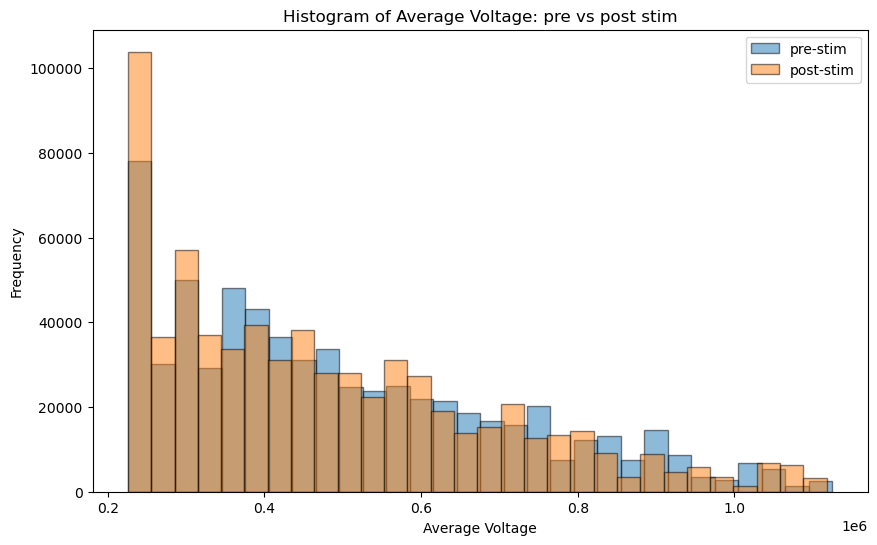

C:\Users\Karl\AppData\Local\Temp\ipykernel_9744\3856836436.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])


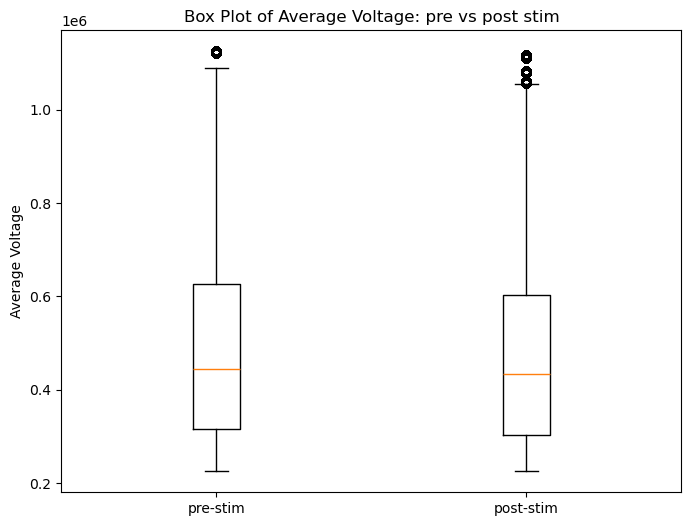

In [22]:

# histogram

pre_data = lmem[lmem['group'] == 'pre-stim']['avg_voltage']
post_data = lmem[lmem['group'] == 'post-stim']['avg_voltage']

plt.figure(figsize=(10, 6))
plt.hist(pre_data, bins=30, alpha=0.5, label='pre-stim', edgecolor='black')
plt.hist(post_data, bins=30, alpha=0.5, label='post-stim', edgecolor='black')
plt.title('Histogram of Average Voltage: pre vs post stim')
plt.xlabel('Average Voltage')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# boxplot

plt.figure(figsize=(8, 6))
data_to_plot = [
    pre_data,
    post_data
]
plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])
plt.title('Box Plot of Average Voltage: pre vs post stim')
plt.ylabel('Average Voltage')
plt.show()


it honestly doesn't look too different - what could the issue be??

### grouping the dataset by "bins" of stimulus

In [23]:

# 1. Define bin edges: we go from 0 to slightly above the max value in steps of 50,000.
max_val = lmem['avg_voltage'].max()
bin_edges = np.arange(0, max_val + 50000, 50000)

# 2. Create labels that match the upper bound of each bin.
#    For instance, bin [0, 50000] gets the label "50000", bin (50000, 100000] gets "100000", etc.
labels = [str(int(x)) for x in bin_edges[1:]]

# 3. Use pd.cut to discretize avg_voltage. 
#    include_lowest=True ensures that 0 goes into the first bin. 
#    With right=True (the default), intervals are (a, b], so 50,000 falls in the first bin.
lmem['voltage_bin'] = pd.cut(lmem['avg_voltage'], 
                           bins=bin_edges, 
                           labels=labels, 
                           include_lowest=True,
                           right=True)

# Now each row has a "voltage_bin" indicating its bin.


# see bin counts
bin_counts = lmem['voltage_bin'].value_counts().sort_index()
print("Number of entries in each bin (uV):")
print(bin_counts)


Number of entries in each bin (uV):
voltage_bin
50000           0
100000          0
150000          0
200000          0
250000     170112
300000     125300
350000     141606
400000     138707
450000     113478
500000      98577
550000      84843
600000      93272
650000      76212
700000      47811
750000      58905
800000      43760
850000      41492
900000      23324
950000      30480
1000000      8082
1050000     14200
1100000     15326
1150000      5776
Name: count, dtype: int64


In [24]:
# Group by 'cluster' and 'voltage_bin' then calc mean firing rate
avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()
# avg_firing_rate["firing_rate"] = avg_firing_rate["firing_rate"].astype(float) # I think it already does this, no need to specify againa
avg_firing_rate.to_csv(SAVE_DIRECTORY / "grouped_stimulus.csv")
avg_firing_rate

C:\Users\Karl\AppData\Local\Temp\ipykernel_9744\16533545.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()


,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,group,firing_rate
24,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,post-stim,39.958594
25,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,pre-stim,21.854076
30,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,300000,5,post-stim,39.958594
31,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,300000,5,pre-stim,21.854076
36,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,350000,5,post-stim,39.958594
...,...,...,...,...,...,...,...
6530802,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,800000,5,post-stim,24.624765
6530803,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,800000,5,pre-stim,15.280965
6530808,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,850000,5,post-stim,24.624765
6530809,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,850000,5,pre-stim,15.280965


IMPORTANT: this code need to drop zero entries, because you can't calculate % change with zero.

In [25]:
# Pivot the data so that pre-stim and post-stim firing rates become separate columns.
pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],
                          columns='group',
                          values='firing_rate').reset_index()


# Remove rows where pre-stim is zero to avoid division by zero
pre_post_pivot = pre_post_pivot[pre_post_pivot['pre-stim'] != 0]


# Drop rows that do not have both pre-stim and post-stim values
pre_post_pivot = pre_post_pivot.dropna(subset=['pre-stim', 'post-stim'])

# Calc percent change, pre to post
pre_post_pivot['percent_change'] = ((pre_post_pivot['post-stim'] - pre_post_pivot['pre-stim']) / pre_post_pivot['pre-stim']) * 100

pre_post_pivot.to_csv(SAVE_DIRECTORY / "percent_change.csv")

pre_post_pivot

C:\Users\Karl\AppData\Local\Temp\ipykernel_9744\1844011097.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],


group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
0,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,250000,5,39.958594,21.854076,82.84275
1,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,300000,5,39.958594,21.854076,82.84275
2,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,350000,5,39.958594,21.854076,82.84275
3,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,400000,5,39.958594,21.854076,82.84275
4,DW322,DW322_VF_1_240918_143256,0.0-DW322_VF_1_240918_143256,450000,5,39.958594,21.854076,82.84275
...,...,...,...,...,...,...,...,...
7769,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,650000,5,24.624765,15.280965,61.146665
7770,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,700000,5,24.624765,15.280965,61.146665
7771,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,750000,5,24.624765,15.280965,61.146665
7772,DW327,DW327_VF_10_241125_162725,9.0-DW327_VF_10_241125_162725,800000,5,24.624765,15.280965,61.146665


# 📈 linear mixed effects model - nested cluster, trial, rat id

MAKE SURE TO DO THIS STEP


when you filter by correlation threshhold, it is going to drop rows and some of the data may refer to old indices.  This can happen if you drop rows (for example, due to missing percent_change values) without resetting the index, so some groups still reference old index values.



this graph is hard to draw any conclusions from - plot the average trend, with std error bars

    #### structure of dataset

    * Rat
        * trial 
            * cluster ID

    #### Predictor/Fixed Variable:
    * Frequency_Hz (categorical: 5, 20, 100 Hz): frequency of DRG stimulation
    #### Random Effects:
    * Rat_ID: Differences in baseline firing changes between animals.
    * Trial_ID (nested within Rat_ID): Trial‐to‐trial variability (per animal).
    * Trial_Cluster: Variability at the neuron level (per trial).

**Model Formula:**

$$
\text{percent\_change\_firing} \sim \text{Frequency\_Hz} + (1 \mid \text{Rat\_ID}) + \{ \text{Trial}: 0 + C(\text{Trial\_ID}),\ \text{Neuron}: 0 + C(\text{Cluster}) \}
$$

#### methods

In [26]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(cluster)',
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz + voltage_bin", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

LinAlgError: Singular matrix

things that could be possible:

1. Multicollinearity - are Frequency and Voltage correlated?
2. Trial_ID cluster have only than one level per group.
3. Trial_ID cluster levels are not overly sparse or redundant with the fixed effects.

In [ ]:
pre_post_pivot['Frequency_Hz'].describe()


In [ ]:
pre_post_pivot['voltage_bin'].describe()

In [ ]:
pre_post_pivot[['Frequency_Hz', 'voltage_bin']].corr()

ok, so these values are not highly correlated. this tells me we don't have enough data then?

In [ ]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(Trial_ID):C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

In [ ]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Neuron': 'C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Trial_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())